In [3]:
!pip install torch
!pip install packaging
!pip uninstall -y ninja && pip install ninja
!pip install flash-attn --no-build-isolation


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 4.8 MB/s eta 0:00:00
  Created wheel for flash-attn: filename=flash_attn-2.3.6-cp310-cp310-linux_x86_64.whl size=56477261 sha256=652ad256d0891cb2c6d7183f96f7f56ff61cdeee24388381abb35e7a0f2eeca1
  Stored in directory: /root/.cache/pip/wheels/24/5f/16/5044cdddb6dfb3331dfbffa28ab6096ec2900777af5cb0253a
Successfully built flash-attn


In [4]:
!pip install jaxtyping

In [5]:
from jaxtyping import Float,Int

In [6]:
from torch import Tensor

In [7]:
from torch import nn
import torch
from flash_attn import flash_attn_qkvpacked_func, flash_attn_func
import einops
import numpy as np
import math

## to do :
ROtary positional encoding

In [8]:
from dataclasses import dataclass

In [9]:

@dataclass
class Config:
    d_model: int = 768  # dimension of the residual_stream
    d_vocab: int = 50257
    n_ctx: int = 1024  # max nb of tokens that the model can handle
    d_head: int = 64  # dimension of each key/query/value
    d_mlp: int = 3072  # dimension of the hidden layer inside the MLPs
    n_heads: int = 12  # Nb of heads
    n_heads_kv : int = 6 ## nb of Key values for Grouped query attention
    n_layers: int = 12  # Nb of (Attention+ MLP) in the GPT

    layer_norm_eps: float = 1e-5  # (Bonus)
    init_range: float = 0.02  # (bonus) standard deviation of 0.02 for weight initialization
    sliding_attention: int = None
    flash_attention: bool = True
    context_size : int = 1024
    pos_type : str = 'sinusoidal'
    device :str ='cpu'


cfg = Config()

In [11]:
from flash_attn.modules.mha import MHA


In [13]:
class NewGELUActivation(nn.Module):
    """
    Implementation of the GELU activation function currently in Google BERT repo (identical to OpenAI GPT). Also see
    the Gaussian Error Linear Units paper: https://arxiv.org/abs/1606.08415
    """

    def forward(self, input: Tensor) -> Tensor:
        return 0.5 * input * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (input + 0.044715 * torch.pow(input, 3.0))))

In [14]:
class Attention(nn.Module):
    IGNORE: Float[Tensor, ""]

    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.W_Q = nn.Parameter(torch.empty((cfg.n_heads, cfg.d_model, cfg.d_head)))
        self.W_K = nn.Parameter(torch.empty((cfg.n_heads, cfg.d_model, cfg.d_head)))
        self.W_V = nn.Parameter(torch.empty((cfg.n_heads, cfg.d_model, cfg.d_head)))
        self.W_O = nn.Parameter(torch.empty((cfg.n_heads, cfg.d_head, cfg.d_model)))
        self.b_Q = nn.Parameter(torch.zeros((cfg.n_heads, cfg.d_head)))
        self.b_K = nn.Parameter(torch.zeros((cfg.n_heads, cfg.d_head)))
        self.b_V = nn.Parameter(torch.zeros((cfg.n_heads, cfg.d_head)))
        self.b_O = nn.Parameter(torch.zeros((cfg.d_model)))
        nn.init.normal_(self.W_Q, std=self.cfg.init_range)
        nn.init.normal_(self.W_K, std=self.cfg.init_range)
        nn.init.normal_(self.W_V, std=self.cfg.init_range)
        nn.init.normal_(self.W_O, std=self.cfg.init_range)
        self.register_buffer("IGNORE", torch.tensor(-1e5, dtype=torch.float32, device=cfg.device))
        self.sliding_attention = cfg.sliding_attention

    def forward(
        self, normalized_resid_pre: Float[Tensor, "batch posn d_model"]
    ) -> Float[Tensor, "batch posn d_model"]:
        batch_size, len_seq = normalized_resid_pre.shape[0], normalized_resid_pre.shape[1]
        repeat_resid = einops.repeat(normalized_resid_pre,
                                     'batch posn d_model -> batch n_heads posn d_model',
                                     n_heads=self.cfg.n_heads)
        key = einops.einsum(self.W_K,repeat_resid,'n_heads d_model d_head, batch n_heads posn d_model -> batch n_heads posn d_head') +\
              einops.repeat(self.b_K,'n_heads d_head -> batch n_heads posn d_head',
                            batch = batch_size,
                            posn=len_seq)
        query = einops.einsum(self.W_Q,repeat_resid,'n_heads d_model d_head, batch n_heads posn d_model -> batch n_heads posn d_head') +\
              einops.repeat(self.b_Q,'n_heads d_head -> batch n_heads posn d_head',
                            batch = batch_size,
                            posn=len_seq)
        value = einops.einsum(self.W_V,repeat_resid,'n_heads d_model d_head, batch n_heads posn d_model -> batch n_heads posn d_head') +\
              einops.repeat(self.b_V,'n_heads d_head -> batch n_heads posn d_head',
                            batch = batch_size,
                            posn=len_seq)


        attn_score = einops.einsum(query,key, 'batch n_heads posn_Q d_model, batch n_heads posn_K d_model -> batch n_heads posn_Q posn_K')/np.sqrt(cfg.d_head)
        attn_score = self.apply_causal_mask(attn_score)
        attn_score = torch.nn.functional.softmax(attn_score,dim=-1) ### ATTENTION ne pas oublier la dimension

        attention_value = einops.einsum(attn_score,value,'batch n_heads posn_Q posn,batch n_heads posn d_head -> batch n_heads posn_Q d_head') ### ATTENTION a bien choisir le bon coté de la matrice

        out = einops.einsum(self.W_O,attention_value,'n_heads d_head d_model, batch n_heads posn d_head -> batch posn d_model') +\
              einops.repeat(self.b_O,'d_model-> batch posn d_model',
                            batch = batch_size,
                            posn=len_seq)


        return out


    def apply_causal_mask(
        self, attn_scores: Float[Tensor, "batch n_heads query_pos key_pos"]
    ) -> Float[Tensor, "batch n_heads query_pos key_pos"]:
        """
        Applies a causal mask to attention scores, and returns masked scores.
        """
        # Define a mask that is True for all positions we want to set probabilities to zero for
        all_ones = torch.ones(attn_scores.size(-2), attn_scores.size(-1), device=attn_scores.device)
        mask = torch.triu(all_ones, diagonal=1).bool()
        if self.sliding_attention : ## if sliding attention each attention block can only attend info within a window
          mask+= torch.tril(all_ones,
                            diagonal=-self.sliding_attention)
        # Apply the mask to attention scores, then return the masked scores
        attn_scores.masked_fill_(mask, self.IGNORE)
        return attn_scores


In [15]:
class MLP(nn.Module):
    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.W_in = nn.Parameter(torch.empty((cfg.d_model, cfg.d_mlp)))
        self.W_out = nn.Parameter(torch.empty((cfg.d_mlp, cfg.d_model)))
        self.b_in = nn.Parameter(torch.zeros((cfg.d_mlp)))
        self.b_out = nn.Parameter(torch.zeros((cfg.d_model)))
        nn.init.normal_(self.W_in, std=self.cfg.init_range)
        nn.init.normal_(self.W_out, std=self.cfg.init_range)
        self.activation = NewGELUActivation()

    def forward(
        self, normalized_resid_mid: Float[Tensor, "batch posn d_model"]
    ) -> Float[Tensor, "batch posn d_model"]:
        batch_size, len_seq = normalized_resid_mid.shape[0],normalized_resid_mid.shape[1]
        intermed = einops.einsum(self.W_in,normalized_resid_mid,
                                 'd_model d_mlp, batch posn d_model -> batch posn d_mlp') +\
                                 einops.repeat(self.b_in,
                                               'd_mlp -> batch posn d_mlp',
                                               batch = batch_size,
                                               posn=len_seq)
        intermed = self.activation(intermed)
        out = einops.einsum(self.W_out,intermed,
                                 'd_mlp d_model, batch posn d_mlp -> batch posn d_model') +\
                                 einops.repeat(self.b_out,
                                               'd_model -> batch posn d_model',
                                               batch = batch_size,
                                               posn=len_seq)
        return out




In [16]:
class PosEmbed(nn.Module):
  def __init__(self, cfg : Config, **kwargs) -> None:
    super().__init__()
    self.cfg = cfg
    self.pos_type = cfg.pos_type
    self.w = (1/10000)**(2/cfg.d_model)
    self.d = cfg.d_model
    if self.pos_type == 'sinusoidal':
      lookup_table = torch.zeros((cfg.context_size+1,
                                  self.d))
      for dim in range(0,cfg.d_model):
        t = torch.arange(cfg.context_size+1)
        k = dim//2
        if dim%2==0:
          encoding = torch.cos(self.w**k*t)
        else :
          encoding = torch.sin(self.w**k*t)
        lookup_table[:,dim] = encoding
      self.lookup_table = lookup_table
      self.pos_encoder = nn.Embedding.from_pretrained(lookup_table)

  def forward(self,x):

      batch,L = x.shape[0],x.shape[1]
      pos_seq = torch.arange(1,L+1)
      pos_encoding = self.pos_encoder(pos_seq)
      return pos_encoding.repeat(batch,1,1)


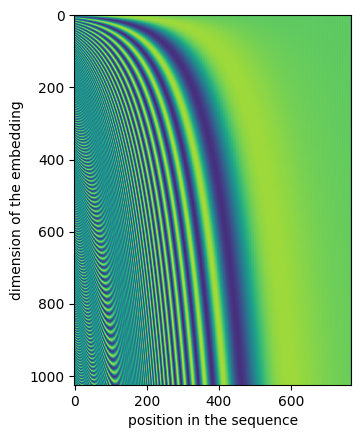

In [32]:
import matplotlib.pyplot as plt
pos_encode = PosEmbed(cfg)
plt.imshow(pos_encode.lookup_table.numpy())
plt.xlabel('position in the sequence')
plt.ylabel('dimension of the embedding')
plt.show()

In [19]:
cfg

Config(d_model=768, d_vocab=50257, n_ctx=1024, d_head=64, d_mlp=3072, n_heads=12, n_heads_kv=6, n_layers=12, layer_norm_eps=1e-05, init_range=0.02, sliding_attention=None, flash_attention=True, context_size=1024, pos_type='sinusoidal', device='cpu')

In [26]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.ln1 = nn.LayerNorm(cfg.d_model)## to change
        if cfg.flash_attention:
          self.attn = MHA(embed_dim = cfg.d_model,
                          num_heads=cfg.n_heads,
                          num_heads_kv = cfg.n_heads_kv) ## check compatibility
        else:
          self.attn = Attention(cfg)
        self.ln2 = nn.LayerNorm(cfg.d_model)
        self.mlp = MLP(cfg)
        self.flash_attention = cfg.flash_attention



    def forward(
        self, resid_pre: Float[Tensor, "batch position d_model"]
    ) -> Float[Tensor, "batch position d_model"]:
        # First, we compute the attention, but the residual stream needs to be normalized beforehand
        resid_mid = resid_pre + self.attn(self.ln1(resid_pre))

        # Then, we compute the MLP, again, the input of the MLP needs to be normalized beforehand
        resid_post = resid_mid + self.mlp(self.ln2(resid_mid))

        return resid_post

In [27]:
class DemoTransformer(nn.Module):
    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.embed = nn.Embedding(cfg.d_vocab,
                                  cfg.d_model)
        self.pos_embed = PosEmbed(cfg)
        self.blocks = nn.ModuleList([TransformerBlock(cfg) for _ in range(cfg.n_layers)])
        self.ln_final = nn.LayerNorm(normalized_shape=cfg.d_model)
        self.unembed = nn.Linear(cfg.d_model,
                                 cfg.d_vocab)

    def forward(
        self, tokens: Int[Tensor, "batch position"]
    ) -> Float[Tensor, "batch position d_vocab"]:
        embedding = self.embed(tokens) + self.pos_embed(tokens)
        for transfo_block in self.blocks:
          embedding = transfo_block(embedding)
        embedding = self.ln_final(embedding)
        predicted = self.unembed(embedding)
        return predicted


In [28]:
transfo = DemoTransformer(cfg)

In [29]:

transfo.embed(torch.zeros((20,30

                     ),dtype=torch.long)).shape

torch.Size([20, 30, 768])

In [30]:
transfo(torch.zeros((20,20),dtype=torch.long)).shape

torch.Size([20, 20, 50257])

In [31]:


transfo.pos_embed(torch.zeros((20,30

                     ),dtype=torch.long)).shape

torch.Size([20, 30, 768])